In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
# 데이터 로드시 빠르게 로드할 수 있는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [7]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


검증셋의 데이터 수가 너무 적기 때문에 훈련과 검증셋을 합쳐서 다시 나눠준다.

In [10]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [13]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [16]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f'Normal images count in training set: {COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f'Pneumonia images count in training set: {COUNT_PNEUMONIA}')

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


폐렴 이미지 수가 정상보다 3배 더 많다. CNN모델의 경우 데이터가 클래스별로 비율이 좋을 수록 훈련을 잘 한다. 클래스 불균형은 이후에 조정한다. 테스트와 검증셋은 평가를 위해 사용되기 때문에 불균형해도 문제없다.

In [17]:
# tf.data 인스턴스 생성. 
# 텐서플로에서 미니배치를 사용할 수 있다.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [21]:
# 훈련, 검증셋 데이터 수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f'Training images count: {TRAIN_IMG_COUNT}')
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f'Validating images count: {VAL_IMG_COUNT}')

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다. 파일 경로에 정상과 폐렴으로 구분되어 있기 대문에 이를 이용해서 라벨 데이터를 만든다. 함수를 만들어서 사용한다.

In [23]:
# 파일 경로 끝에서 두번째를 확인한다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA' # 폐렴이면 True, 노말이면 False

In [24]:
# 이미지 형식 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 크기 조정
    return img

# 이미지와 라벨 읽어오기
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지 형식 변경
    return img, label

훈련, 검증 셋을 만든다. 

In [30]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

잘 동작이 됐는지 확인하기

In [31]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [33]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

    - shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

    - repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

    - batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

    - prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [35]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

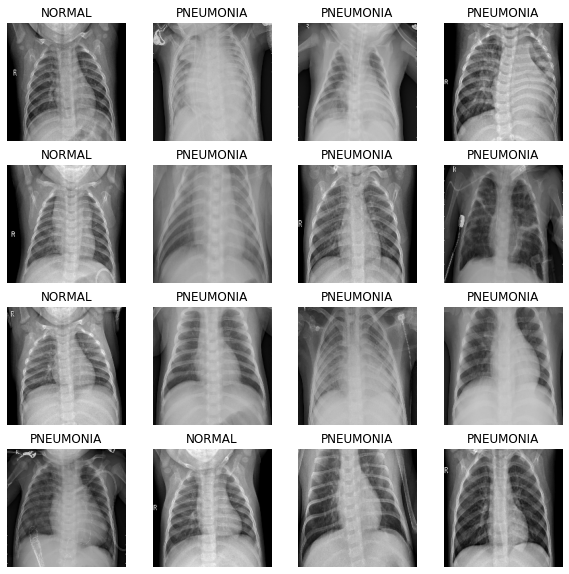

In [36]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링

In [39]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [40]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [41]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 불균형 처리

데이터 불균형을 처리할 때 `Weight balancing`을 사용한다. 훈련셋의 각 데이터의 손실을 계산할 때 특정 클래스의 데이터에 더 큰 손실값을 갖도록 가중치를 부여한다.  

In [42]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 훈련

- 훈련은 GPU를 사용하기 때문에 GPU를 지정한다. 

- 이미지 라벨은 두가지 뿐이어서 `binary_cross entropy`를 사용한다.

In [43]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 90s 197ms/step - loss: 0.4261 - accuracy: 0.7761 - precision: 0.9462 - recall: 0.7413 - val_loss: 0.5828 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2200 - accuracy: 0.9157 - precision: 0.9755 - recall: 0.9096 - val_loss: 1.0809 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1810 - accuracy: 0.9325 - precision: 0.9780 - recall: 0.9303 - val_loss: 0.2250 - val_accuracy: 0.9019 - val_precision: 0.8840 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 50s 194ms/step - loss: 0.1762 - accuracy: 0.9370 - precision: 0.9791 - recall: 0.9353 - val_loss: 0.1126 - val_accuracy: 0.9635 - val_precision: 0.9972 - val_recall: 0.9527
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1599 - accura

### 결과 확인

그래프로 Epochs마다 결과가 어떻게 변하는지 확인한다.

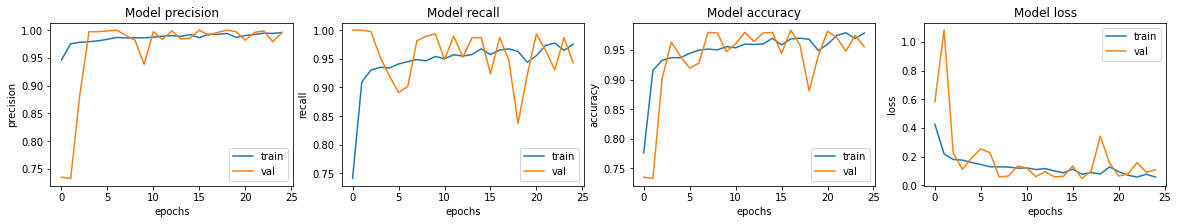

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델을 평가해본다.

In [46]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 102ms/step - loss: 0.6812 - accuracy: 0.8462 - precision: 0.8114 - recall: 0.9821
Loss: 0.6811556816101074,
Accuracy: 0.8461538553237915,
Precision: 0.8114407062530518,
Recall: 0.9820512533187866
